<center>
<h1>
Impact of Data Imputation on Model Performance<br>
(Use SimpleImputer(), KNNImputer with LogisticRegresion, RandomForestClassifier)<hr>
~ Different imputation strategies can affect the quality of predictions, especially in datasets with missing values ~
</h1>
</center>

# Sadržaj


1. Uvod  


2. Eksplorativna analiza podatka (EDA)  

    2.1. Istraživanje distribucije ključnih kliničkih varijabli <br>
    2.2. Analiza korelacije

3. Deskriptivna statistika  


4. Imputacija nedostajućih vrijednosti

    4.1. Simple Imputer <br>
    4.2. KNN Imputer

5. Modeliranje i evaluacija

    5.1. Korištenje dva modela strojnog učenja za predviđanje "Overall Survival Status" <br>

        5.1.1. Logistic Regression
        5.1.2. Random Forest Classifier



6. Intervali pouzdanosti


7. Testiranje hipoteza


8. Zaključak


9. Literatura




In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import normaltest, mannwhitneyu
from scipy.stats import chi2_contingency


# Uvod

[Link na podatke](https://www.cbioportal.org/study/clinicalData?id=breast_msk_2018)<br>


In [ ]:
# Učitavanje podataka
data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t')

Skup podataka o raku dojke sadrži kliničke informacije o pacijentima oboljelima od ove vrste karcinoma. Podaci obuhvaćaju ključne karakteristike poput dobi pacijenata, menopauzalnog statusa u trenutku dijagnoze, statusa hormona (estrogenskog receptora - ER, progesteronskog receptora - PR, HER2 proteina), stadija bolesti u trenutku dijagnoze te podataka o preživljavanju pacijenata. Ovi podaci pružaju vrijedne informacije koje mogu pomoći u razumijevanju različitih učinaka dijagnoze i liječenja raka dojke.

Cilj analize ovog skupa podataka je istražiti čimbenike koji utječu na dijagnozu, liječenje i ishode pacijenata. Poseban naglasak stavlja se na ispitivanje utjecaja različitih strategija imputacije podataka na performanse modela strojnog učenja, budući da u medicinskim skupovima podataka često nedostaju ključne informacije. Osim toga, analiza ima za cilj otkriti obrasce koji pridonose boljem razumijevanju bolesti, kao i identifikaciju čimbenika koji utječu na učinkovitost različitih terapijskih pristupa.

Ova analiza doprinosi razvoju medicine, omogućavajući bolju prilagodbu liječenja individualnim karakteristikama pacijenata. Na taj način može se poboljšati preživljavanje pacijenata, kao i ukupna kvaliteta života osoba oboljelih od raka dojke.

In [ ]:
# Broj stupaca
print("\nUkupan broj stupaca:", len(data.columns))

# Ispis imena svih stupaca
print(data.columns)


Ukupan broj stupaca: 59
Index(['Study ID', 'Patient ID', 'Sample ID', 'Cancer Type',
       'Cancer Type Detailed', 'Disease Free Event', 'Disease Free (Months)',
       'ER PCT Primary', 'ER Status of Sequenced Sample',
       'ER Status of the Primary', 'Fraction Genome Altered',
       'HER2 FISH Status of Sequenced Sample',
       'HER2 FISH Ratio Value of Sequenced Sample', 'HER2 FISH Ratio Primary',
       'HER2 FISH Status (Report and ASCO) of Primary',
       'HER2 IHC Status Primary', 'HER2 IHC Score of Sequenced Sample',
       'HER2 IHC Status of Sequenced Sample', 'HER2 IHC Score Primary',
       'HER2 Primary Status', 'Overall HR Status of Sequenced Sample',
       'Invasive Carcinoma Diagnosis Age',
       'Time to Diagnosis Invasive Carcinoma', 'Last Communication Contact',
       'Primary Tumor Laterality', 'M Stage', 'Menopausal Status At Diagnosis',
       'Metastatic Disease at Last Follow-up', 'Metastatic Recurrence Time',
       'Mutation Count', 'N Stage', 'NGS S

In [ ]:
data = data.drop(columns=['Study ID', 'Patient ID', 'Sample ID'])

Iz dataseta isključujemo stupce "Study ID", "Patient ID" i "Sample ID" jer nam informcije koje su tu sadržane neće kasnije pomoći u predviđanju niti analizi podataka.

# Eksplorativna analiza podataka (EDA)

**Eksplorativna analiza podataka** (EDA) je ključni korak u procesu analize podataka koji pomaže u razumijevanju karakteristika podataka. EDA obuhvaća nekoliko važnih dijelova, uključujući pregled podataka, analizu distribucije varijabli, provjeru odnosa među značajkama, identifikaciju nedostajućih podataka, identifikaciju outliera (iznimnih vrijednosti) i druge slične analize.

In [ ]:
data.shape

(1918, 56)

DataFrame ima 1918 redaka i 59 stupaca

In [ ]:
print(f"U datasetu ima {data.shape[0]*data.shape[1]} podataka.")

U datasetu ima 107408 podataka.


Sada ćemo prikazati prva dva reda u DataFrame-u.

In [ ]:
data.head(n=2)

,Cancer Type,Cancer Type Detailed,Disease Free Event,Disease Free (Months),ER PCT Primary,ER Status of Sequenced Sample,ER Status of the Primary,Fraction Genome Altered,HER2 FISH Status of Sequenced Sample,HER2 FISH Ratio Value of Sequenced Sample,...,Sample Type,Sex,Somatic Status,Stage At Diagnosis,T Stage,Time To Death (Months),TMB (nonsynonymous),Tumor Sample Histology,Tumor Tissue Origin,Patient's Vital Status
0,Breast Cancer,Breast Invasive Ductal Carcinoma,1,1.1,70,Positive,Positive,NaN,NaN,NaN,...,Primary,Female,Matched,IV,T1c,NaN,0.133333,Breast Invasive Ductal Carcinoma,Breast,Alive
1,Breast Cancer,Breast Invasive Ductal Carcinoma,0,218.0,0,Negative,Negative,0.6891,NaN,NaN,...,Primary,Female,Matched,IIA,T2,NaN,0.033333,Breast Invasive Ductal Carcinoma,Breast,Alive


In [ ]:
# Ispis osnovnih informacija o datasetu
print("Informacije o datasetu:")
print(data.info())

Informacije o datasetu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 56 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Cancer Type                                    1918 non-null   object 
 1   Cancer Type Detailed                           1918 non-null   object 
 2   Disease Free Event                             1918 non-null   int64  
 3   Disease Free (Months)                          1918 non-null   float64
 4   ER PCT Primary                                 1709 non-null   object 
 5   ER Status of Sequenced Sample                  1918 non-null   object 
 6   ER Status of the Primary                       1918 non-null   object 
 7   Fraction Genome Altered                        1896 non-null   float64
 8   HER2 FISH Status of Sequenced Sample           505 non-null    object 
 9   HER2 FISH Ratio Value of Seq

In [ ]:
# Brojanje jedinstvenih vrijednosti za kategorijske stupce Cancer Type i Sex
cancer_type_counts = data['Cancer Type'].value_counts()
sex_counts = data['Sex'].value_counts()
print(cancer_type_counts)
print(sex_counts)

Cancer Type
Breast Cancer         1907
Breast Cancer, NOS      11
Name: count, dtype: int64
Sex
Female    1907
Male        11
Name: count, dtype: int64


Prema broju jedinstvenih vrijednosti za dana dva stupca možemo uvidjeti neuravnoteženu distribuciju podataka. Za varijablu "Cancer Type", gotovo svi uzorci (1907) odnose se na "Breast Cancer", dok mali broj (11) se odnosi na "Breast Cancer, NOS" (može značiti "Not Otherwise Specified" - ta oznaka se koristi kada dijagnoza raka dojke nije dodatno klasificirana u specifični podtip raka). Za varijablu "Sex", većina pacijenata (1907) su žene, što je očekivano za rak dojke, dok samo 11 pacijenata čine muškarci, kod kojih je pojava ovog raka rijetka.

## Istraživanje distribucije ključnih kliničkih varijabli

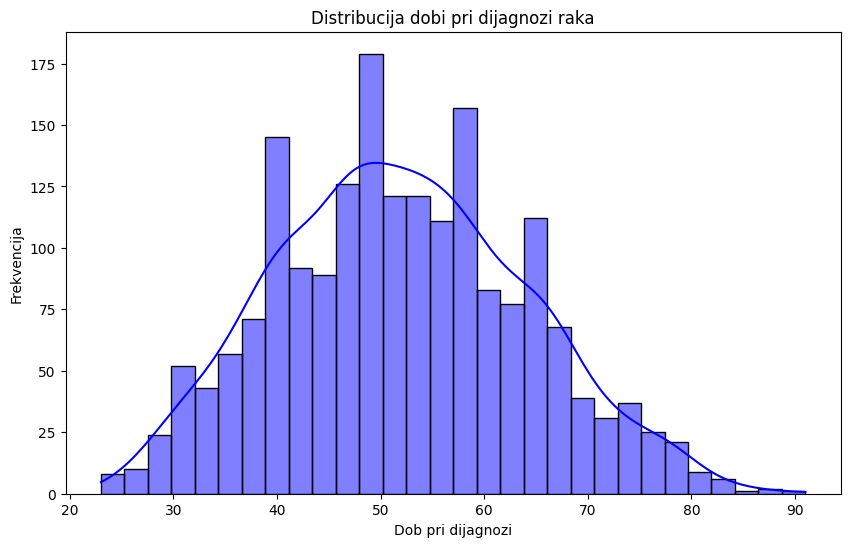

In [ ]:
# Istraživanje distribucije ključnih varijabli
plt.figure(figsize=(10, 6))
sns.histplot(data['Invasive Carcinoma Diagnosis Age'], kde=True, bins=30, color='blue')
plt.title('Distribucija dobi pri dijagnozi raka')
plt.xlabel('Dob pri dijagnozi')
plt.ylabel('Frekvencija')
plt.show()

Iz dane vizualizacije je vidljivo da najveći broj pacijenata spada u dobni raspon između 50 i 60 godina, a dob od 50 godina se odražava kao najviši vrh na histogramu.
Distribucija je približno simetrična i podsjeća na normalnu distribuciju, ali s blagim pomakom prema desnoj strani.
Manje je dijagnoza kod mlađih od 30 godina i starijih od 80 godina.

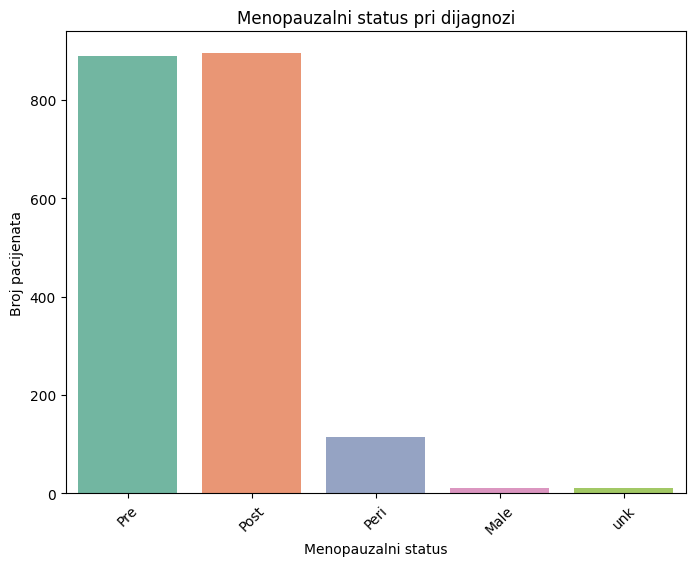

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Menopausal Status At Diagnosis', hue='Menopausal Status At Diagnosis', palette='Set2', legend=False)
plt.title('Menopauzalni status pri dijagnozi')
plt.xlabel('Menopauzalni status')
plt.ylabel('Broj pacijenata')
plt.xticks(rotation=45)
plt.show()

Imamo pet različitih kategorija menopauzalnog statusa pacijenata:

Pre: Premenopauza (pacijentice još nisu ušle u menopauzu)

Post: Postmenopauza (pacijentice su već prošle menopauzu)

Peri: Perimenopauza (pacijentice su u prijelaznom razdoblju prema menopauzi)

Male: Muški pacijenti

unk: Nepoznati status (nepoznata vrijednost)

Ova distribucija ukazuje da je rak dojke najčešće dijagnosticiran kod žena u premenopauzi i postmenopauzi, što je i očekivano s obzirom na poznate rizike povezane s hormonima i dobi.

Iz ovoga možemo uvidjeti kako menopauzalni status može biti značajan faktor u razvoju raka dojke i pruža osnovu za daljnje analize i ciljane intervencije.

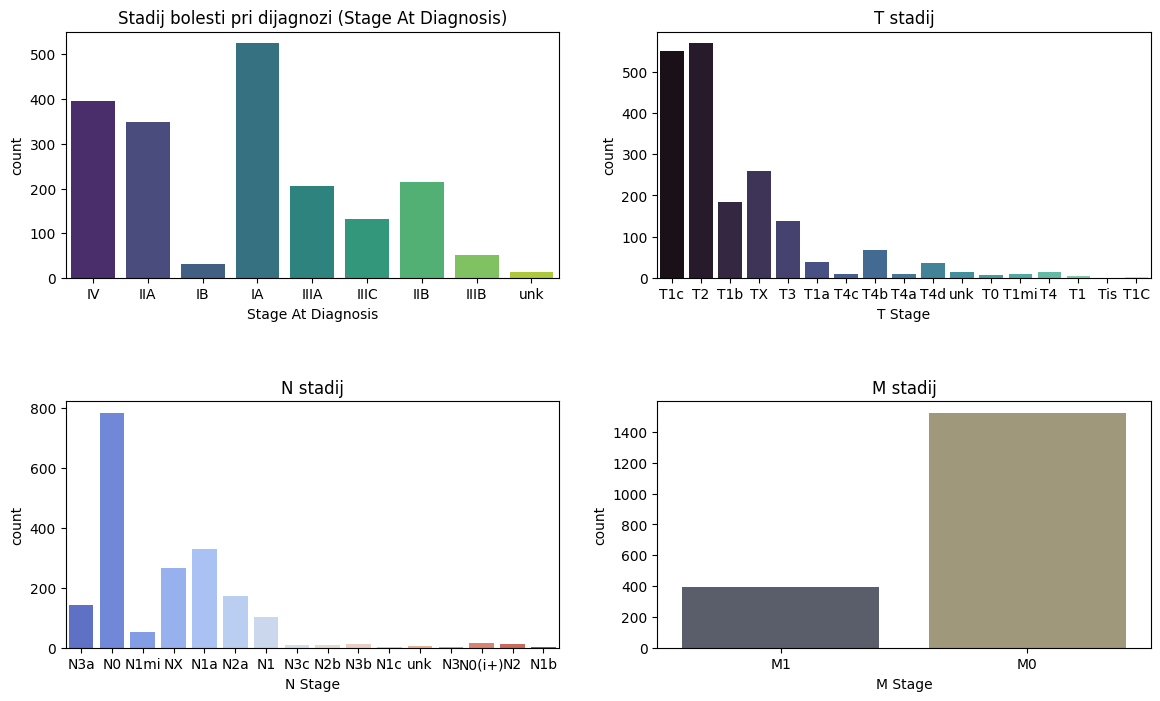

In [ ]:
# Stadij bolesti pri dijagnozi
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

sns.countplot(data=data, x='Stage At Diagnosis',  hue='Stage At Diagnosis', ax=ax[0, 0], palette='viridis', dodge=False)
sns.countplot(data=data, x='T Stage', hue='T Stage', ax=ax[0, 1], palette='mako', dodge=False)
sns.countplot(data=data, x='N Stage', hue='N Stage', ax=ax[1, 0], palette='coolwarm', dodge=False)
sns.countplot(data=data, x='M Stage', hue='M Stage', ax=ax[1, 1], palette='cividis', dodge=False)

ax[0, 0].set_title('Stadij bolesti pri dijagnozi (Stage At Diagnosis)')
ax[0, 1].set_title('T stadij')
ax[1, 0].set_title('N stadij')
ax[1, 1].set_title('M stadij')

# Povećanje razmaka
plt.subplots_adjust(hspace=0.5)

plt.show()

* **Stadij bolesti pri dijagnozi (Stage At Diagnosis)** :
Na gornjem lijevom grafu možemo vidjeti distribuciju stadija bolesti pri dijagnozi. Najviše pacijenata je dijagnosticirano u stadiju IA (više od 500 slučajeva). Ostali stadiji sa značajnim brojem pacijenata su IV i IIA, dok su IB, IIIB i nepoznati stadiji ("unk") najrjeđi. Prema tome možemo zaključiti da je većina pacijenata dijagnosticirana u ranijim fazama bolesti (IA), ali postoji i značajan broj onih s uznapredovalim stadijem bolesti (IV).

* **T Stadij (T Stage) - Tumor Stadij** :
Na gornjem desnom grafu možemo vidjeti distribucuju stadija tumora. T2 je najčešće zabilježeni stadij tumora (više od 500 slučajeva). T1c, TX i T1b također imaju značajan broj slučajeva, dok su napredniji stadiji poput T4b i T4 rjeđi. TX označava nepoznat stadij tumora, što ukazuje na manjak podataka za neke pacijente.

* **N Stadij (N stage) - Čvorni stadij**:
Na donjem lijevom grafu možemo vidjeti distribuciju čvornog stadija. N0 (bez zahvaćenih limfnih čvorova) je najčešći slučaj, s preko 700 uzoraka. Manje zastupljeni stadiji su N1a, N1 i N2a, dok su napredni stadiji poput N3, N3a, N3b ili nepoznati slučajevi ("unk") rjeđi. Ovo ukazuje na to da većina pacijenata nema metastaze u limfnim čvorovima pri dijagnozi.

* **M Stadij (M stage) - Metastatski stadij**:
Na donjem desnom grafu možemo vidjeti distribuciju metastatskog stadija. M0 (nema udaljenih metastaza) dominira s velikom većinom slučajeva. M1 (prisustvo udaljenih metastaza) je mnogo rjeđi. Ovo ukazuje na to da je kod većine pacijenata bolest dijagnosticirana prije nego što su se razvile udaljene metastaze .

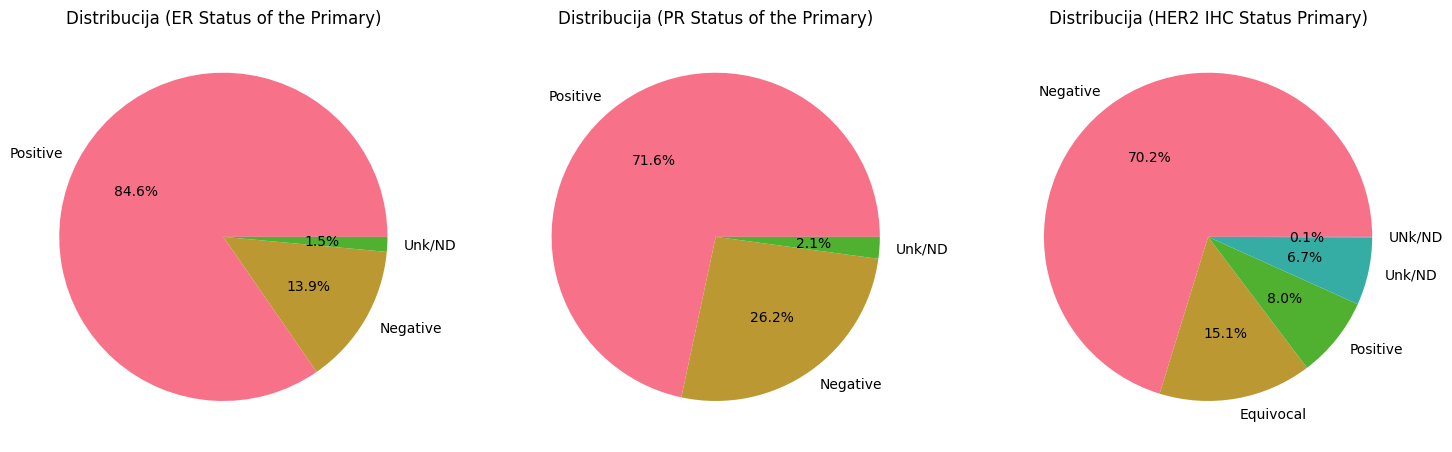

In [ ]:
# Status hormona
hormone_cols = ['ER Status of the Primary', 'PR Status of the Primary', 'HER2 IHC Status Primary']

fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # jedan red, tri dijagrama

for i, col in enumerate(hormone_cols):
    data[col].value_counts().plot.pie(
        ax=ax[i],
        autopct='%1.1f%%',
        colors=sns.color_palette('husl'),
        textprops={'fontsize': 10}  # Veličina fonta
    )
    ax[i].set_title(f'Distribucija ({col})', fontsize=12)
    ax[i].set_ylabel('')


plt.show()

Iz danih vizualizacija povezanih uz status hormona "ER Status of the Primary"
(ER - estrogenski receptor), "PR Status of the Primary" (PR - progesteronski receptor), "HER2 IHC Status Primary" kod pacijenata oboljelih od raka dojke možemo zaključiti da je većina tumora hormonski ovisna (pozitivni ER i PR status), što može ukazivati na mogućnost liječenja hormonskom terapijom.
Za HER2 prevladava negativan status, dok je manji postotak pacijenata s HER2 pozitivnim statusom, što može utjecati na izbor ciljane terapije.


Distribucija ciljne varijable ('Overall Survival Status'):
Overall Survival Status
0:LIVING      1496
1:DECEASED     422
Name: count, dtype: int64


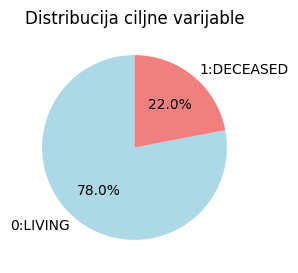

In [ ]:
# Provjera postojanja ciljne varijable
if 'Overall Survival Status' in data.columns:
    print("\nDistribucija ciljne varijable ('Overall Survival Status'):")
    print(data['Overall Survival Status'].value_counts())

    # Vizualizacija distribucije
    plt.figure(figsize=(5, 3))
    data['Overall Survival Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
    plt.title('Distribucija ciljne varijable')
    plt.ylabel('')
    plt.show()
else:
    print("Ciljna varijabla 'Overall Survival Status' nije pronađena u datasetu.")


Prikazana je pie chart vizualizacija distribucije ciljne varijable "Overall Survival Status", koja ukazuje na to koliko pacijenata pripada svakoj od klasa:

Klasa 0 (78%): Ova klasa označava pacijente koji nisu preminuli tijekom perioda praćenja bolesti (preživjeli).

Klasa 1 (22%): Ova klasa označava pacijente koji su preminuli tijekom perioda praćenja bolesti.

## Analiza korelacije

In [ ]:
# Pretvaranje ciljne varijable u numerički oblik (kodiranje kategoričke varijable)
data['Overall Survival Status'] = data['Overall Survival Status'].map({'0:LIVING': 0, '1:DECEASED': 1})

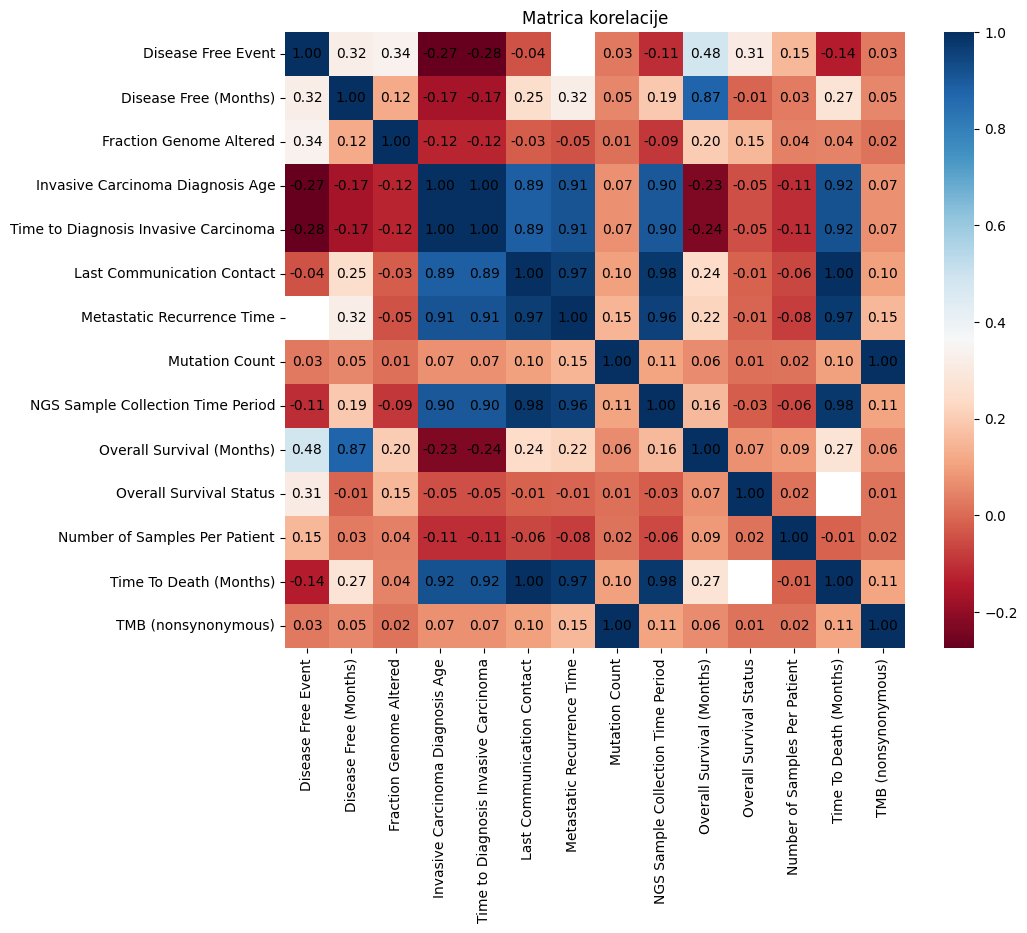

In [ ]:
numerical_data = data.select_dtypes(include='number')

correlation_matrix = numerical_data.corr()

# Prikaz matrice korelacije
plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu',
    cbar=True,
    annot_kws={"color": "black"}  # Postavlja crna slova za oznake
)

plt.title('Matrica korelacije')
plt.show()

U danoj matrici korelacije vidimo četiri bijele šupljine bez ikakvih vrijednosti čemu su najvjerojatnije uzrok nedostajuće vrijednosti u stupcima koji utječu na rezultat na tom mjestu u matrici. Stoga, prije ponovnog prikazivanja matrice korelacije, za početak, te nedostajuće vrijednosti ćemo popuniti medijanom za svaki numerički stupac.

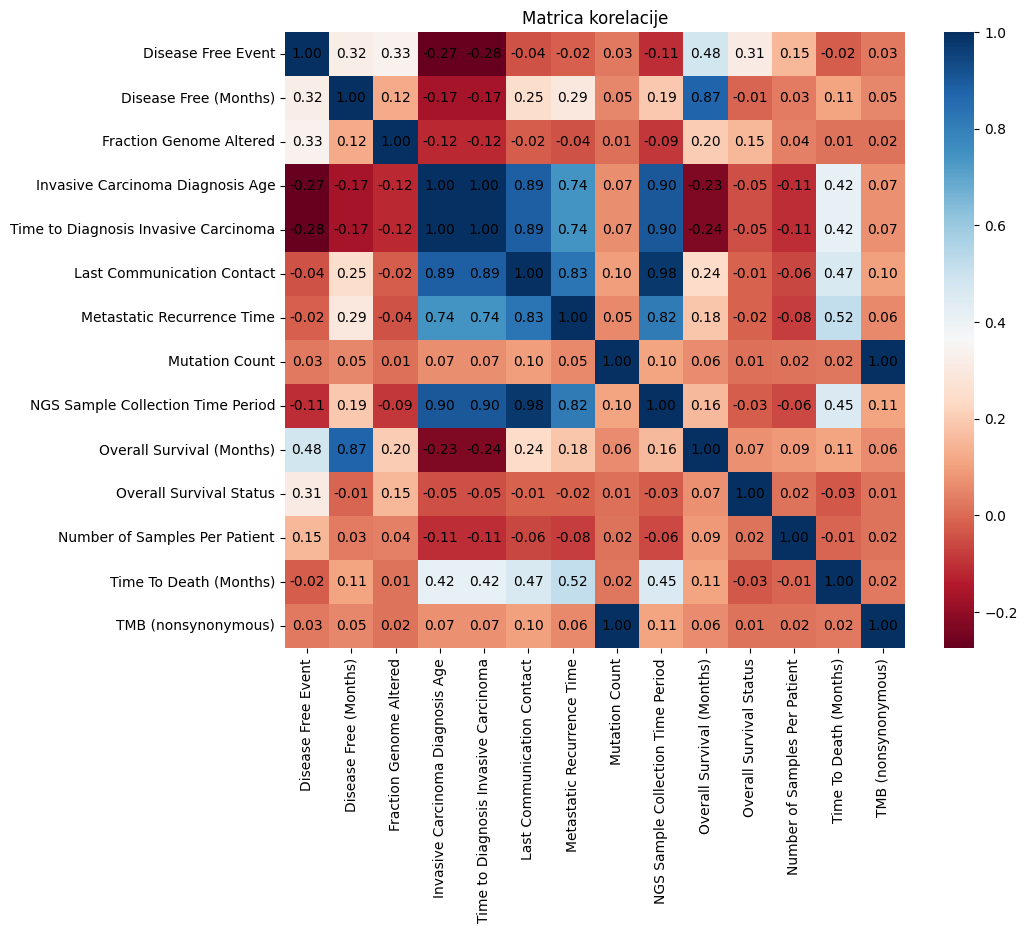

In [ ]:
# Popunjavanje nedostajućih vrijednosti s medijanom
numerical_data = numerical_data.apply(lambda x: x.fillna(x.median()))

# Matrica korelacije
correlation_matrix = numerical_data.corr()

# Prikaz matrice korelacije
plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu',
    cbar=True,
    annot_kws={"color": "black"}  # Postavlja crna slova za oznake
)

plt.title('Matrica korelacije')
plt.show()


Iz dane matrice korelacije možemo očiti korelaciju 0.90 između "NGS Sample Collection Time Period" i "Time to Diagnosis Invasive Carcinoma", što znači da ove dvije varijable pokazuju jaku korelaciju.
Prema tome možemo zaključiti da su zapravo povezane s istim vremenskim razdobljem, vrijeme prikupljanja uzorka za genetsku analizu (NGS) može biti određeno neposredno nakon dijagnoze invazivnog karcinoma.<br>
Nadalje, pozitivna korelacija između "Overall Survival (Months)" i "Disease Free (Months)" od 0.87 ukazuje da pacijenti koji duže žive bez povratka bolesti obično imaju i dulje ukupno preživljenje.<br>
Zatim, srednje jaka korelacija između "Metastatic Recurrence Time" i "Time To Death (Months)" (0.52) pokazuje da dulje razdoblje bez povratka metastaza obično prati dulje ukupno preživljenje.<br>
S druge strane, relativno slaba korelacija od -0.28 između "Disease Free Event" i "Time to Diagnosis Invasive Carcinoma" ukazuje na slabu povezanost, što znači da pacijenti s dužim vremenom do dijagnoze invazivnog karcinoma imaju nešto manju vjerojatnost ostati bez povratka bolesti.

# Deskriptivna statistika

In [ ]:
# Deskriptivna statistika za numeričke podatke
print("\nDeskriptivna statistika - osnovne statističke informacije o numeričkim stupcima:")
data.describe()


Deskriptivna statistika - osnovne statističke informacije o numeričkim stupcima:


,Disease Free Event,Disease Free (Months),Fraction Genome Altered,Invasive Carcinoma Diagnosis Age,Time to Diagnosis Invasive Carcinoma,Last Communication Contact,Metastatic Recurrence Time,Mutation Count,NGS Sample Collection Time Period,Overall Survival (Months),Overall Survival Status,Number of Samples Per Patient,Time To Death (Months),TMB (nonsynonymous)
count,1918.000000,1918.000000,1896.000000,1918.000000,1918.000000,1918.000000,1406.000000,1834.000000,1918.000000,1918.000000,1918.000000,1918.000000,422.000000,1918.000000
mean,0.733055,39.094056,0.318959,51.965589,624.478603,20992.866006,649.968706,5.045802,666.134515,65.995255,0.220021,1.189781,687.203791,0.160966
std,0.442479,53.505631,0.218368,12.069693,144.931298,4414.348721,143.620002,11.285033,146.396524,69.222396,0.414368,0.471913,144.422007,0.368018
min,0.000000,0.000000,0.000000,23.000000,271.510000,8841.000000,297.000000,1.000000,288.000000,0.700000,0.000000,1.000000,336.000000,0.000000
25%,0.000000,4.300000,0.142475,43.000000,517.987500,17900.750000,545.000000,2.000000,563.250000,14.100000,0.000000,1.000000,589.750000,0.066667
50%,1.000000,15.750000,0.297350,51.000000,618.340000,21082.500000,655.000000,4.000000,668.000000,43.200000,0.000000,1.000000,692.500000,0.133333
75%,1.000000,53.175000,0.470575,60.000000,724.160000,24293.000000,754.000000,6.000000,778.750000,92.025000,0.000000,1.000000,789.000000,0.200000
max,1.000000,379.600000,1.000000,91.000000,1092.470000,33407.000000,1041.000000,447.000000,1093.000000,403.700000,1.000000,4.000000,1058.000000,14.833333


Iz danog data.describe() možemo iščitati neke statistike o našem skupu podataka.

Podaci pokazuju da je prosječno ukupno preživljenje pacijenata, prema stupcu **"Overall Survival (Months)"**, 66 mjeseci (oko 5.5 godina), s velikom varijabilnošću (standardna devijacija 69 mjeseci), pri čemu minimalno preživljenje iznosi 0.7 mjeseci, a maksimalno čak 403.7 mjeseci (oko 33 godine). Iz stupca **"Invasive Carcinoma Diagnosis Age"** vidljivo je da je prosječna dob dijagnoze raka dojke 52 godine, s rasponom od 23 do 91 godine, što ukazuje na utjecaj bolesti u širokom rasponu životnih dobi. Prema stupcu **"Disease Free (Months)"**, vrijeme bez bolesti traje prosječno 39 mjeseci, ali varira od 0 do 380 mjeseci. Podaci o vremenu do smrti, zabilježeni u stupcu **"Time to Death (Months)"**. Vidimo da su dostupni za manji broj pacijenata, s prosjekom od 687 mjeseci (oko 57 godina).

In [ ]:
# Podjela na značajke (X) i ciljnu varijablu (y)
X = data.drop('Overall Survival Status', axis=1)
y = data['Overall Survival Status']

# Izdvajanje numeričkih podataka
X = X.select_dtypes(include=[np.number])

In [ ]:
# Ispis naziva stupaca u X
print("Nazivi stupaca u X:")
print(f"{X.columns.tolist()}\n i ima ih {X.shape[1]}")

Nazivi stupaca u X:
['Disease Free Event', 'Disease Free (Months)', 'Fraction Genome Altered', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Last Communication Contact', 'Metastatic Recurrence Time', 'Mutation Count', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Number of Samples Per Patient', 'Time To Death (Months)', 'TMB (nonsynonymous)']
 i ima ih 13


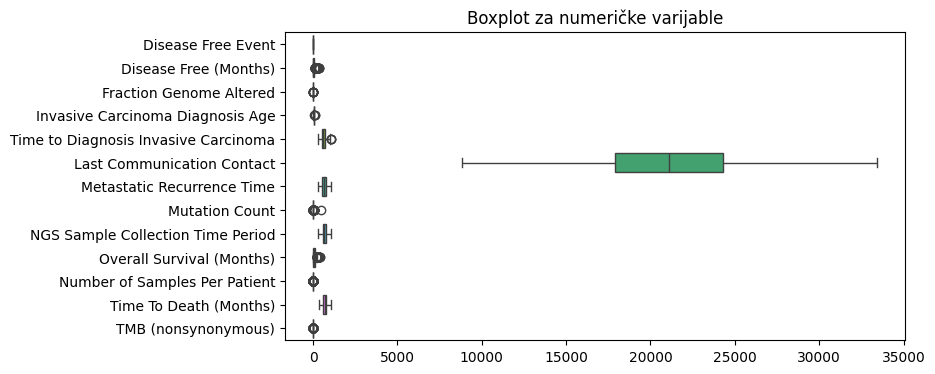

In [ ]:
# Boxplot za svaku numeričku varijablu
plt.figure(figsize=(8, 4))
sns.boxplot(data=X, orient='h')
plt.title('Boxplot za numeričke varijable')
plt.show()

Iz danih boxplot dijagrama možemo zaključiti da skoro sve numeričke varijable imaju vrlo male raspone i vrijednosti koje su blizu 0, što ukazuje na nisku varijabilnost. Ovo može značiti da je većina pacijenata unutar uskog raspona za ove značajke ili da ove značajke sadrže puno vrijednosti blizu nule. Izuzetak je jedna značajka s velikim vrijednostima - "Last Communication Contact". Ova značajka ima vrijednosti koje su i preko 20000. IQR - interkvartilni raspon je relativno velik, što ukazuje na značajnu varijabilnost u srednjih 50% podataka.
Outlieri nisu vidljivi, što ukazuje da su svi podaci u granicama.

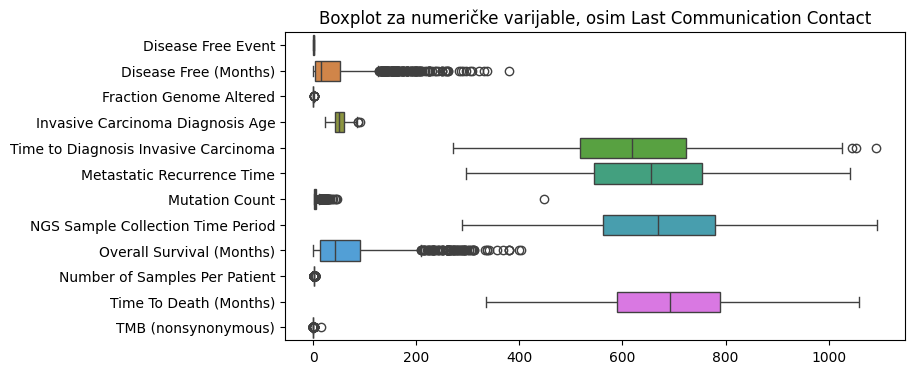

In [ ]:
# Boxplot za svaku numeričku varijablu, osim Last Communication Contact
plt.figure(figsize=(8, 4))
sns.boxplot(data=X.drop('Last Communication Contact', axis=1), orient='h')
plt.title('Boxplot za numeričke varijable, osim Last Communication Contact')
plt.show()

Na danom boxplot dijagramu smo izbacili stupac "Last Communication Contact" te  nam se sada manji rasponi ostalih varijabli mogu bolje uočiti. Varijable poput "NGS Sample Collection Time Period" i "Time to Death (Months)" pokazuju šire raspone. Izuzetci su posebno izraženi kod značajki poput "Disease Free (Months)". Ova analiza naglašava potencijalnu važnost značajki s većim rasponima za daljnja istraživanja.

In [ ]:
# Identifikacija outliera pomoću IQR (Interquartile Range)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Definiranje outliera
outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR)))
print("\nBroj outliera po varijabli:")
print(outliers.sum())


Broj outliera po varijabli:
Disease Free Event                        0
Disease Free (Months)                   152
Fraction Genome Altered                   9
Invasive Carcinoma Diagnosis Age          3
Time to Diagnosis Invasive Carcinoma      3
Last Communication Contact                0
Metastatic Recurrence Time                0
Mutation Count                           86
NGS Sample Collection Time Period         0
Overall Survival (Months)                94
Number of Samples Per Patient           306
Time To Death (Months)                    0
TMB (nonsynonymous)                      98
dtype: int64


# Imputacija nedostajućih vrijednosti

In [ ]:
# Nedostajuće vrijednosti
missing_values = data.isna().sum()

# Postotak nedostajućih vrijednosti po stupcima
missing_percentage = (missing_values / len(data)) * 100

print("\nNedostajuće vrijednosti po stupcima:")
missing_summary = pd.DataFrame({
    'Broj nedostajućih': missing_values,
    'Postotak (%)': missing_percentage.round(2).astype(str) + '%'
})
print(missing_summary)


Nedostajuće vrijednosti po stupcima:
                                               Broj nedostajućih Postotak (%)
Cancer Type                                                    0         0.0%
Cancer Type Detailed                                           0         0.0%
Disease Free Event                                             0         0.0%
Disease Free (Months)                                          0         0.0%
ER PCT Primary                                               209        10.9%
ER Status of Sequenced Sample                                  0         0.0%
ER Status of the Primary                                       0         0.0%
Fraction Genome Altered                                       22        1.15%
HER2 FISH Status of Sequenced Sample                        1413       73.67%
HER2 FISH Ratio Value of Sequenced Sample                   1524       79.46%
HER2 FISH Ratio Primary                                     1320       68.82%
HER2 FISH Status (Report a

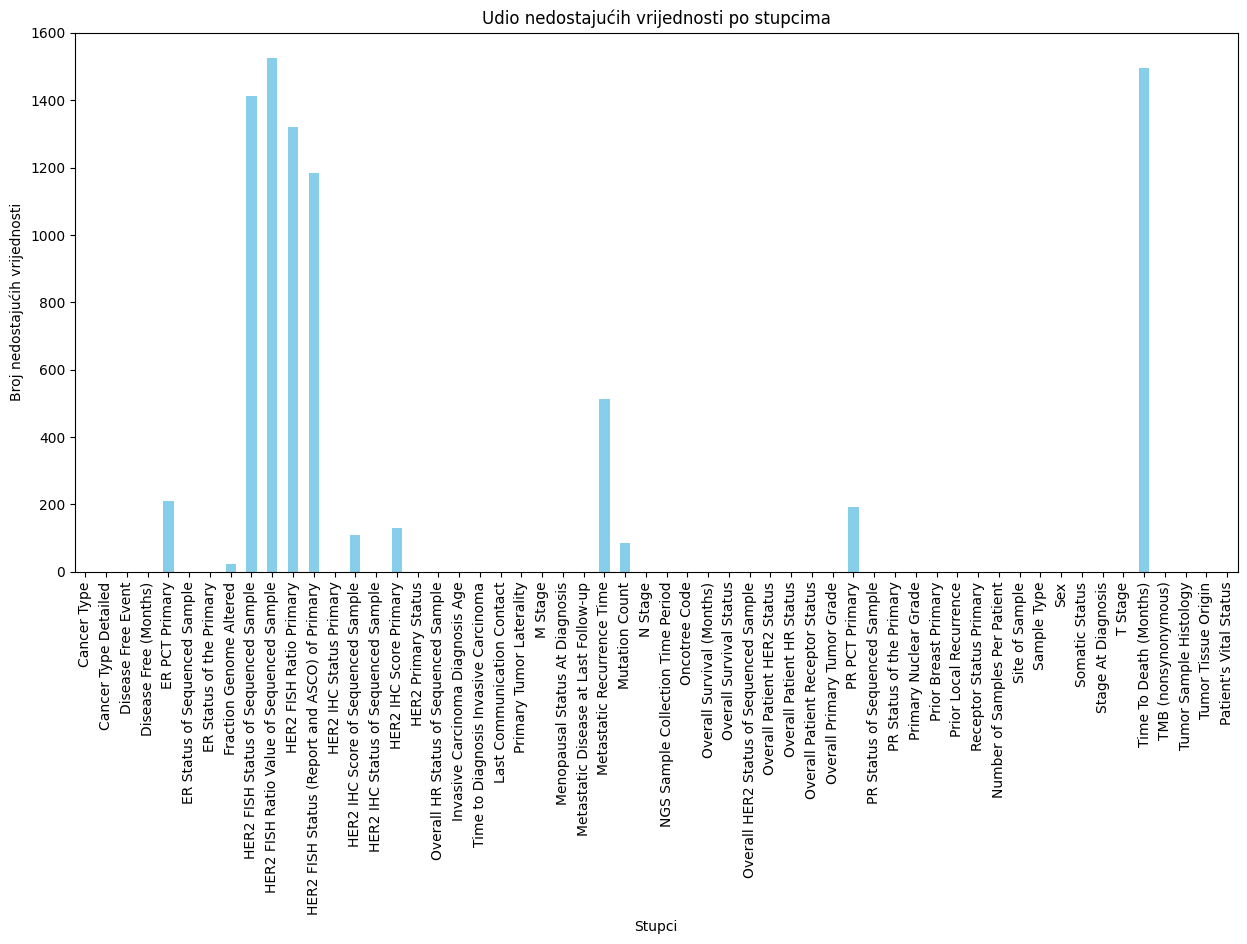

In [ ]:
# Vizualizacija broja nedostajućih vrijednosti po stupcima
plt.figure(figsize=(15, 7))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Udio nedostajućih vrijednosti po stupcima')
plt.ylabel('Broj nedostajućih vrijednosti')
plt.xlabel('Stupci')
plt.show()

Dakle, možemo vidjeti da od naših 59 stupaca, njih 12 sadrži nedostajuće vrijednosti, a od tih 12 stupaca 5 ih sadrži čak 60% - 70% nedostajućih vrijednosti.

Napravit ćemo funkcije koje kasnije možemo koristiti za evaluacije različitih modela u kombinaciji sa svakom od metoda imputacije podataka.

Random Forest Classifier nije osjetljiv na skaliranje podataka, ali Logistic Regression je pa ćemo unutar funkcija napraviti i skaliranje. Za predviđanje ćemo odabrati 10 značajki(od naših numeričkih) korištenjem SelectKBest sa f_classif koji dabire 10 najboljih značajki na temelju ANOVA F-vrijednosti. SelectKBest pomaže smanjiti dimenzionalnost i potencijalni overfitting.

Koristimo f_classif jer je namijenjen za selekciju značajki u slučajevima kada su ulazne varijable numeričke, a ciljna varijabla je kategorijska. ANOVA F-vrijednost analizira povezanost između svake numeričke značajke i ciljne varijable, što je korisno za modele poput Logistic Regression. S druge strane, chi2 se koristi kada su i ulazne značajke i ciljna varijabla kategorijske, pa nije prikladan za numeričke podatke.

## Simple Imputer

Prvo ćemo napraviti funkciju za evaluaciju modela, pri čemu imputaciju podataka vršimo koristeći Simple Imputer. Unutar ove funkcije biramo i najbolju strategiju za Simple Imputer metodu imputacije podataka.

In [ ]:
def evaluate_model_with_simpleimputer(imputer, model, X, y, model_name, imputer_name, print_results=False):

    results=[]
    # Imputacija podataka koristeći SimpleImputer
    imputer_strategies = ['mean', 'median', 'most_frequent']
    best_strategy = None
    best_f1_score = 0
    best_model = None
    best_params = None
    selected_features = None

    # Odabir najbolje strategije za imputaciju
    for strategy in imputer_strategies:
        imputer.strategy = strategy
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

        # Odabir najboljih 10 značajki pomoću SelectKBest
        selector = SelectKBest(score_func=f_classif, k=10)
        X_selected = selector.fit_transform(X_imputed, y)

        # Dohvaćanje odabranih značajki
        selected_features = X_imputed.columns[selector.get_support()]
        X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

        # Skaliranje značajki
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_selected_df)

        # Podjela na skupove za treniranje i testiranje
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Parametri za GridSearch za modele
        param_grid = {}

        if model_name == "Logistic Regression":
            param_grid = {'max_iter': [100, 200, 500, 1000]}
        elif model_name == "Random Forest":
            param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, 30]}

        # GridSearch za modele
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Najbolji model
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        f1 = f1_score(y_test, y_pred, average='weighted')

        if f1 > best_f1_score:
            best_f1_score = f1
            best_strategy = strategy
            best_params = grid_search.best_params_

    results.append({
        'Imputer': imputer_name,
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': best_f1_score,
        'Best Params': best_params,
        'Selected Features': list(selected_features),
        'Best Imputation Strategy': best_strategy
    })

    if print_results:
        print(f"\nZnačajke koje koristimo za predviđanje: {list(selected_features)}")
        print(f"\nNajbolji parametri za {model_name} sa strategijom {imputer_name}: {best_params}")
        print(f"Najbolja strategija imputacije: {best_strategy}")

        print(f"\nIzvještaj o klasifikaciji za {model_name} sa strategijom {imputer_name}:")
        print(classification_report(y_test, y_pred, zero_division=1))

        # Matrica konfuzije
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(2, 1))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_search.best_estimator_.classes_,
            yticklabels=grid_search.best_estimator_.classes_)
        plt.gca().invert_yaxis()
        plt.title(f'Matrica konfuzije za {model_name} sa {imputer_name}\n')
        plt.xlabel('Predviđene klase')
        plt.ylabel('Stvarne klase')
        plt.show()

        # Analiza matrice konfuzije
        correct_predictions = cm.diagonal().sum()
        incorrect_predictions = cm.sum() - correct_predictions
        print(f"Točno klasificirani podaci: {correct_predictions}")
        print(f"Pogrešno klasificirani podaci: {incorrect_predictions}")
        print(f"Postotak ispravno klasificiranih podataka: {correct_predictions / cm.sum() * 100:.2f}%")


Točnost nije dovoljna metrika za neuravnotežene podatke jer model može postići visoku točnost predviđajući samo većinsku klasu, zanemarujući manju, ali važnu klasu. Metrike poput F1-mjere omogućuju bolju procjenu modela, uzimajući u obzir performanse za obje klase, posebno i za manjinsku. Zato kao metriku promatramo F1-mjeru, iako smo računali i točnost, jer je ciljna varijabla "Overall Survival Status" neuravnotežena (78% preživjeli i 22% nepreživjeli).

Kao strategije za Simple Imputer smo postavili mean, median i most_frequent, a constant smo izostavili jer kada većina podataka nedostaje, imputacija s konstantnom vrijednošću, primjerice 0, može pogrešno preusmjeriti model, dajući previše važnosti nuli i zanemarujući stvarne vrijednosti, čime se smanjuje preciznost predviđanja.

## KNN Imputer

Nadalje, napravit ćemo funkciju za evaluaciju modela koristeći KNN Imputer za imputaciju podataka. Pronaći ćemo i najbolju vrijednost parametra k - broj susjeda za KNN Imputer.

In [ ]:
def evaluate_model_with_knn_imputer(imputer, model, X, y, model_name, imputer_name, print_results=False):

    results=[]
    # Imputacija podataka koristeći KNNImputer
    k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    best_k = None
    best_f1_score = 0
    best_model = None
    best_params = None
    selected_features = None

    # Odabir najboljeg k za imputaciju
    for k in k_values:
        imputer.n_neighbors = k
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

        # Odabir najboljih 10 značajki pomoću SelectKBest
        selector = SelectKBest(score_func=f_classif, k=10)
        X_selected = selector.fit_transform(X_imputed, y)

        # Dohvaćanje odabranih značajki
        selected_features = X_imputed.columns[selector.get_support()]
        X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

        # Skaliranje značajki
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_selected_df)

        # Podjela na skupove za treniranje i testiranje
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Parametri za GridSearch za modele
        param_grid = {}

        if model_name == "Logistic Regression":
            param_grid = {'max_iter': [100, 200, 500, 1000]}
        elif model_name == "Random Forest":
            param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, 30]}

        # GridSearch za modele
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Najbolji model
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        f1 = f1_score(y_test, y_pred, average='weighted')

        if f1 > best_f1_score:
            best_f1_score = f1
            best_k = k
            best_params = grid_search.best_params_

    results.append({
        'Imputer': imputer_name,
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': best_f1_score,
        'Best Params': best_params,
        'Selected Features': list(selected_features),
        'Best K for Imputation': best_k
    })

    if print_results:
        print(f"\nZnačajke koje koristimo za predviđanje: {list(selected_features)}")
        print(f"\nNajbolji parametri za {model_name} sa strategijom {imputer_name}: {best_params}")
        print(f"Najbolji k za KNN imputaciju: {best_k}")

        print(f"\nIzvještaj o klasifikaciji za {model_name} sa strategijom {imputer_name}:")
        print(classification_report(y_test, y_pred, zero_division=1))

        # Matrica konfuzije
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(2, 1))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_search.best_estimator_.classes_,
            yticklabels=grid_search.best_estimator_.classes_)
        plt.gca().invert_yaxis()
        plt.title(f'Matrica konfuzije za {model_name} sa {imputer_name}\n')
        plt.xlabel('Predviđene klase')
        plt.ylabel('Stvarne klase')
        plt.show()

        # Analiza matrice konfuzije
        correct_predictions = cm.diagonal().sum()
        incorrect_predictions = cm.sum() - correct_predictions
        print(f"Točno klasificirani podaci: {correct_predictions}")
        print(f"Pogrešno klasificirani podaci: {incorrect_predictions}")
        print(f"Postotak ispravno klasificiranih podataka: {correct_predictions / cm.sum() * 100:.2f}%")


# Modeliranje i evaluacija

## Korištenje dva modela strojnog učenja za predviđanje "Overall Survival Status"

In [ ]:
# Inicijalizacije
simple_imputer = SimpleImputer()
knn_imputer = KNNImputer()

logistic_model = LogisticRegression(random_state=42, class_weight='balanced')

random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced')

Kako je ciljna varijabla "Overall Survival Status" neuravnotežena (78% preživjeli i 22% nepreživjeli) koristimo **class_weight='balanced'** što nam pomaže da model automatski prilagođava težinu svake klase prema njenoj učestalosti u podacima. Za manjinsku klasu, model povećava težinu pogrešnih predviđanja, čime ga potiče da više obraća pažnju na tu klasu, a za većinsku klasu smanjuje težinu, jer se većina podataka već nalazi u toj klasi. To smanjuje pristranost modela prema većinskoj klasi, poboljšavajući performanse na manjinskoj klasi.

### Random Forest Classifier


Značajke koje koristimo za predviđanje: ['Disease Free Event', 'Fraction Genome Altered', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Mutation Count', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Number of Samples Per Patient', 'Time To Death (Months)', 'TMB (nonsynonymous)']

Najbolji parametri za Random Forest sa strategijom Simple Imputer: {'max_depth': 5, 'n_estimators': 100}
Najbolja strategija imputacije: median

Izvještaj o klasifikaciji za Random Forest sa strategijom Simple Imputer:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       299
           1       1.00      0.98      0.99        85

    accuracy                           0.99       384
   macro avg       1.00      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384



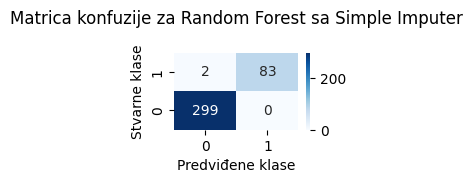

Točno klasificirani podaci: 382
Pogrešno klasificirani podaci: 2
Postotak ispravno klasificiranih podataka: 99.48%


In [ ]:
evaluate_model_with_simpleimputer(simple_imputer, random_forest_model, X, y, "Random Forest", "Simple Imputer", print_results=True)


Značajke koje koristimo za predviđanje: ['Disease Free Event', 'Fraction Genome Altered', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Metastatic Recurrence Time', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Number of Samples Per Patient', 'Time To Death (Months)', 'TMB (nonsynonymous)']

Najbolji parametri za Random Forest sa strategijom KNN Imputer: {'max_depth': 20, 'n_estimators': 200}
Najbolji k za KNN imputaciju: 6

Izvještaj o klasifikaciji za Random Forest sa strategijom KNN Imputer:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       299
           1       0.42      0.15      0.22        85

    accuracy                           0.77       384
   macro avg       0.61      0.55      0.54       384
weighted avg       0.71      0.77      0.72       384



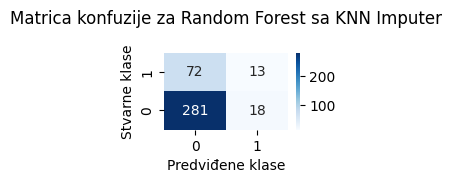

Točno klasificirani podaci: 294
Pogrešno klasificirani podaci: 90
Postotak ispravno klasificiranih podataka: 76.56%


In [ ]:
evaluate_model_with_knn_imputer(knn_imputer, random_forest_model, X, y, "Random Forest", "KNN Imputer", print_results=True)

### Logistic Regression


Značajke koje koristimo za predviđanje: ['Disease Free Event', 'Fraction Genome Altered', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Mutation Count', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Number of Samples Per Patient', 'Time To Death (Months)', 'TMB (nonsynonymous)']

Najbolji parametri za Logistic Regression sa strategijom Simple Imputer: {'max_iter': 100}
Najbolja strategija imputacije: most_frequent

Izvještaj o klasifikaciji za Logistic Regression sa strategijom Simple Imputer:
              precision    recall  f1-score   support

           0       0.96      0.52      0.68       299
           1       0.35      0.92      0.51        85

    accuracy                           0.61       384
   macro avg       0.65      0.72      0.59       384
weighted avg       0.82      0.61      0.64       384



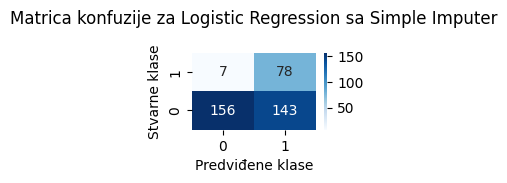

Točno klasificirani podaci: 234
Pogrešno klasificirani podaci: 150
Postotak ispravno klasificiranih podataka: 60.94%


In [ ]:
evaluate_model_with_simpleimputer(simple_imputer, logistic_model, X, y, "Logistic Regression", "Simple Imputer", print_results=True)


Značajke koje koristimo za predviđanje: ['Disease Free Event', 'Fraction Genome Altered', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Metastatic Recurrence Time', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Number of Samples Per Patient', 'Time To Death (Months)', 'TMB (nonsynonymous)']

Najbolji parametri za Logistic Regression sa strategijom KNN Imputer: {'max_iter': 100}
Najbolji k za KNN imputaciju: 2

Izvještaj o klasifikaciji za Logistic Regression sa strategijom KNN Imputer:
              precision    recall  f1-score   support

           0       0.99      0.44      0.61       299
           1       0.34      0.99      0.50        85

    accuracy                           0.57       384
   macro avg       0.66      0.72      0.56       384
weighted avg       0.85      0.57      0.59       384



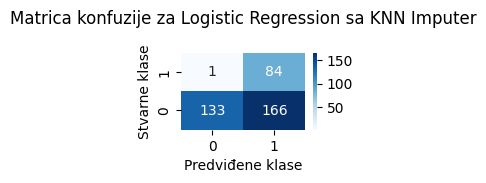

Točno klasificirani podaci: 217
Pogrešno klasificirani podaci: 167
Postotak ispravno klasificiranih podataka: 56.51%


In [ ]:
evaluate_model_with_knn_imputer(knn_imputer, logistic_model, X, y, "Logistic Regression", "KNN Imputer", print_results=True)

# Intervali pouzdanosti

Za analizu intervala pouzdanosti odabrala sam stupac **"Invasive Carcinoma Diagnosis Age"**, jer je od ključne važnosti razumjeti u kojoj dobi se najčešće dijagnosticira rak. Na taj način možemo pravovremeno poslati pozive ženama koje spadaju u taj dobni raspon, s ciljem ranog otkrivanja raka.

In [ ]:
# Srednja vrijednost i standardna greška
mean_age = np.mean(X['Invasive Carcinoma Diagnosis Age'])
std_err = stats.sem(X['Invasive Carcinoma Diagnosis Age'], nan_policy='omit')

# Z-vrijednosti za različite razine pouzdanosti
z_values = {'90%': 1.65, '95%': 1.96, '99%': 2.58, '99.9%': 3.291}

print(f"Srednja vrijednost dobi pri dijagnozi raka: {mean_age:.2f}")

# Iteracija kroz razine pouzdanosti
for pouzdanost, z_value in z_values.items():
    margin_of_error = z_value * std_err
    lower_bound = mean_age - margin_of_error
    upper_bound = mean_age + margin_of_error
    print(f"\n{pouzdanost} pouzdani interval povjerenja\n\t<{lower_bound:.2f}, {upper_bound:.2f}>")


Srednja vrijednost dobi pri dijagnozi raka: 51.97

90% pouzdani interval povjerenja
	<51.51, 52.42>

95% pouzdani interval povjerenja
	<51.43, 52.51>

99% pouzdani interval povjerenja
	<51.25, 52.68>

99.9% pouzdani interval povjerenja
	<51.06, 52.87>


Dani rezultati predstavljaju intervale pouzdanosti za srednju vrijednost dobi pri dijagnozi raka, izračunate za različite razine pouzdanosti.

**Interpretacija 90% pouzdanog intervala**:
s pouzdanošću od 90%, srednja vrijednost dobi pri dijagnozi raka u populaciji nalazi se između 51.51 i 52.42 godine. Ovaj interval je uži nego što bi bio za višu razinu pouzdanosti, jer niže razine pouzdanosti omogućuju manji raspon za preciznost procjene.

Širi interval = veća sigurnost. Kako se razina pouzdanosti povećava (npr. s 90% na 99.9%), interval se širi jer uključuje više mogućih vrijednosti.

# Testiranje hipoteza

Sada ćemo testirati statističku značajnost razlike "Invasive Carcinoma Diagnosis Age" između skupina kojima je "Overall Survival Status" jednak 0 i onih kojima je jednak 1.

**Nul hipoteza (H0):** Razlika u "Invasive Carcinoma Diagnosis Age" između skupine s "Overall Survival Status" jednakim 0 i skupine s "Overall Survival Status" jednakim 1 nije statistički značajna.<br>
**Alternativna hipoteza (H1):** Razlika u "Invasive Carcinoma Diagnosis Age" između skupine s "Overall Survival Status" jednakim 0 i skupine s "Overall Survival Status" jednakim 1 je statistički značajna.

Uzimamo razinu značajnosti $\alpha$ = 0.05.

In [ ]:
# Podjela na dvije skupine s obzirom na Overall Survival Status
group_0 = data[data['Overall Survival Status'] == 0]['Invasive Carcinoma Diagnosis Age']
group_1 = data[data['Overall Survival Status'] == 1]['Invasive Carcinoma Diagnosis Age']

stat_0, pvalue_0 = normaltest(group_0)
stat_1, pvalue_1 = normaltest(group_1)

print(f"pvalue_0: {pvalue_0:.4f}")
print(f"pvalue_0 < 0.05: {pvalue_0 < 0.05}\n")

print(f"pvalue_1: {pvalue_1:.4f}")
print(f"pvalue_1 < 0.05: {pvalue_1 < 0.05}")

pvalue_0: 0.0000
pvalue_0 < 0.05: True

pvalue_1: 0.1207
pvalue_1 < 0.05: False


Iako je p-vrijednost za skupinu 1 veća od 0.05 (što upućuje na normalnu distribuciju), budući da skupina 0 nije normalno distribuirana, koristit ćemo neparametarski Mann-Whitney U test.

In [ ]:
stat, pvalue = mannwhitneyu(group_0, group_1)

print(f"pvalue: {pvalue:.4f}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 0.0673
pvalue < 0.05: False


p-vrijednost je nije manja od 0.05

Ne odbacujemo  H0, tj. zaključujemo: Razlika u Invasive Carcinoma Diagnosis Age između skupine s Overall Survival Status jednakim 0 i skupine s Overall Survival Status jednakim 1 nije statistički značajna.

Sada ćemo provesti Chi-squared test za povezanost ER statusa i preživljavanja.

**H0:** Preživljavanje i ER status nisu povezani.

**H1:** Preživljavanje i ER status su povezani.

In [ ]:
# Chi-squared test za ER status
contingency_table = pd.crosstab(data['ER Status of the Primary'], data['Overall Survival Status'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-squared stat: {chi2:.2f}")
print(f"p-vrijednost: {p:.2f}")

Chi-squared stat: 52.20
p-vrijednost: 0.00


# Zaključak

Random Forest Classifier sa Simple Imputer-om daje najbolje rezultate. Vidimo da postiže visoku F1-mjeru za obje klase. Ovo ukazuje na odličnu ravnotežu između preciznosti i odziva. Uz parametre max_depth=5 i n_estimators=100, model učinkovito prepoznaje obje klase s vrlo malim brojem grešaka.<br>
S druge strane, Random Forest s KNN Imputer-om ima dobar rezultat za klasu 0 (F1-mjera = 0.86), ali značajno slabiji za klasu 1 (F1.mjera = 0.22). Ovdje model vrlo dobro prepoznaje slučajeve klase 0(preživjeli tijekom procesa praćenja bolesti), ali ne prepoznaje dovoljno dobro slučajeve klase 1(preminuli tijekom procesa praćenja bolesti), što rezultira niskim odzivom za klasu 1 i slabo balansiranim rezultatima.

Nadalje, Logistic Regression sa Simple Imputer-om pokazuje prosječne rezultate, s F1-mjerama 0.68 za klasu 0 i 0.51 za klasu 1. Iako model daje prihvatljive rezultate za klasu 0, ima slabiju preciznost i odziv za klasu 1, što znači da ne prepoznaje dovoljno slučajeve te klase, čime je njegova učinkovitost niža u odnosu na Random Forest.<br>
Logistic Regression s KNN Imputer-om ima visoku preciznost za klasu 0 (99%), ali nizak odziv (44%), dok za klasu 1 ima visok odziv (99%) s niskom preciznošću (34%), što rezultira slabom ukupnom F1-mjerom (0.56). Ovaj model ima lošu ravnotežu između preciznosti i odziva, što ga čini manje učinkovitijim u odnosu na Random Forest sa Simple Imputer-om.

Zaključno, Random Forest sa Simple Imputer-om je najučinkovitiji model, jer osigurava visoku točnost i ravnotežu između preciznosti i odziva za obje klase, dok ostali modeli, osobito s KNN Imputer-om, pokazuju slabije rezultate.









# Literatura

* [https://scikit-learn.org/1.6/modules/generated/sklearn.impute.SimpleImputer.html](https://scikit-learn.org/1.6/modules/generated/sklearn.impute.SimpleImputer.html)

* [https://scikit-learn.org/1.5/modules/generated/sklearn.impute.KNNImputer.html](https://scikit-learn.org/1.5/modules/generated/sklearn.impute.KNNImputer.html)

* [https://colab.research.google.com/drive/1DnLX1ZbdSBcI3gXUOG3KzVLj5498Dv-q#scrollTo=OXcGx4AqjI-U&line=7&uniqifier=1](https://colab.research.google.com/drive/1DnLX1ZbdSBcI3gXUOG3KzVLj5498Dv-q#scrollTo=OXcGx4AqjI-U&line=7&uniqifier=1)

* [https://www.mamo.hr/objava/stadij-karcinoma-dojke](https://www.mamo.hr/objava/stadij-karcinoma-dojke)

* [https://medium.com/@jairiidriss/the-importance-of-feature-scaling-in-machine-learning-logistic-regression-for-example-b3068f8d3441](https://medium.com/@jairiidriss/the-importance-of-feature-scaling-in-machine-learning-logistic-regression-for-example-b3068f8d3441)

* [https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

* [https://www.geeksforgeeks.org/introduction-to-python-tabulate-library/](https://www.geeksforgeeks.org/introduction-to-python-tabulate-library/)

* [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html)